In [ ]:
,import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the pickled working dataset obtained from data_extraction.ipynb.

In [ ]:
def getfile(f, **kwargs):
  loc = 'https://drive.google.com/uc?export=download&id='+f.split('/')[-2]
  out = pd.read_pickle(loc, **kwargs)
  return out

f = "https://drive.google.com/file/d/1pltF9KHbAy4UPCin6W_qI317A6-xaCdT/view?usp=drive_link"
df = getfile(f)
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020


Convert DateTime objects to float values.

In [ ]:
df['Date'] = df['Date_Numeric'].dt.to_period('M')
df['Date'] = df['Date'].dt.to_timestamp().apply(lambda x : pd.Timestamp(x).to_julian_date())
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


Drop redundant columns.

In [ ]:
df.drop(['Year', 'Month', 'Date_Numeric'], axis='columns', inplace=True)
df.head()

,Area Name,Area Type,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


Convert categorical variables to numerical values. Drop one dummy variable in each category to prevent multicollinearity.

In [ ]:
categorical_cols = ['Area Name', 'Area Type', 'Seasonally Adjusted(Y/N)', 'Status', 'Benchmark']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,Labor Force,Employment,Unemployment,Unemployment Rate,Date,Area Name_Adelanto city,Area Name_Agoura Hills city,Area Name_Alameda County,Area Name_Alameda city,Area Name_Alamo CDP,...,Area Name_Yuba County,Area Name_Yucaipa city,Area Name_Yucca Valley town,Area Type_Metropolitan Area,Area Type_State,Area Type_Sub-County Place,Seasonally Adjusted(Y/N)_Y,Status_Preliminary,Benchmark_2021,Benchmark_2023
0,9672362,8668016,1004346,10.4,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,9774280,8875685,898595,9.2,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
2,9684440,8704564,979876,10.1,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,9768885,8871553,897332,9.2,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
4,9689626,8776344,913282,9.4,2442838.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df.shape

(204096, 1032)

In [ ]:
X = df.drop('Unemployment Rate', axis=1).values
y = df['Unemployment Rate'].values

#Scaling feature
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Prepare sequential data
timesteps = 1
X_seq = X.reshape((X.shape[0], timesteps, X.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([163276, 1, 1031])
X_test shape: torch.Size([40820, 1, 1031])
y_train shape: torch.Size([163276, 1])
y_test shape: torch.Size([40820, 1])


# Build a deep learning model for the dataset

In [ ]:
# Build the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # self.hidden_fc = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

input_size = X_seq.shape[2]  # Number of features
hidden_size = 100  # Number of RNN units
output_size = 1  # Predicting a single value (unemployment rate)
num_layers = 2  # Number of RNN layers

model = RNNModel(input_size, hidden_size, output_size, num_layers)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training
epochs = 100
history = {"train_loss": []}
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    history["train_loss"].append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 43.4999
Epoch [20/100], Loss: 24.1458
Epoch [30/100], Loss: 15.3353
Epoch [40/100], Loss: 11.0723
Epoch [50/100], Loss: 8.8069
Epoch [60/100], Loss: 7.5436
Epoch [70/100], Loss: 6.7647
Epoch [80/100], Loss: 6.2172
Epoch [90/100], Loss: 5.9020
Epoch [100/100], Loss: 5.5632


In [ ]:
# Evaluating the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse_loss = mean_squared_error(y_test, y_pred)
    mae_loss = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

print(f'MSE Loss: {mse_loss}')
print(f'MAE Loss: {mae_loss}')
print(f'R2 Score: {r2}')

MSE Loss: 5.730888843536377
MAE Loss: 1.4026198387145996
R2 Score: 0.8947934004165552


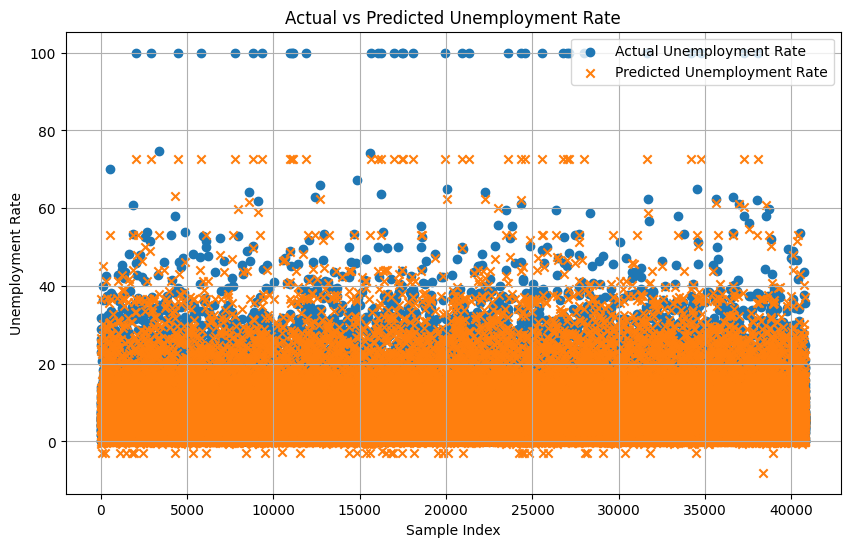

In [ ]:
y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(y_test_np)), y_test_np, label='Actual Unemployment Rate', marker='o')
plt.scatter(np.arange(len(y_test_np)), y_pred_np, label='Predicted Unemployment Rate', marker='x')
plt.title('Actual vs Predicted Unemployment Rate')
plt.xlabel('Sample Index')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()

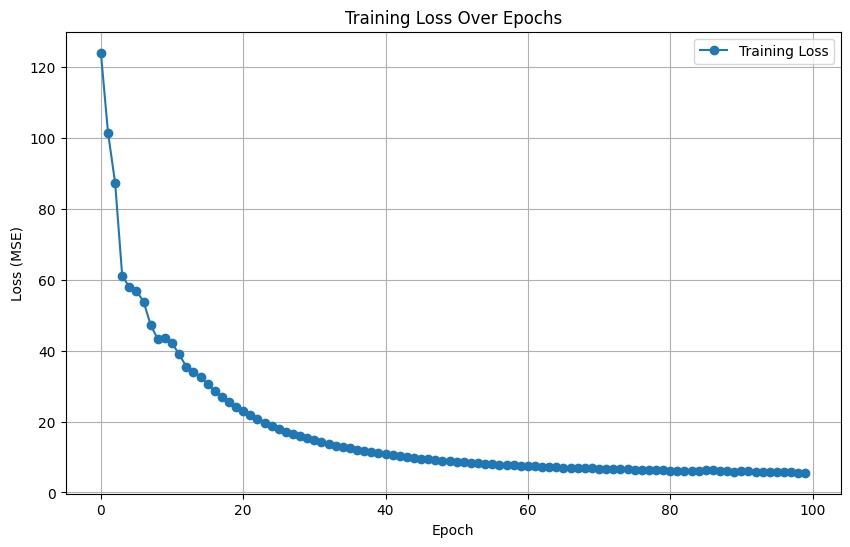

In [ ]:
training_loss = history["train_loss"]
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()